In [158]:
import numpy as np
import matplotlib.pyplot as plt
import camb
from scipy.interpolate import interp1d

## Creating target power spectrum

In [159]:
Omega_b= 0.05
Omega_c = 0.25

h=0.7
As = 2.1e-09
ns = 0.96

pars = camb.CAMBparams()
pars.set_cosmology(H0=100*h, ombh2=Omega_b*h**2, omch2=Omega_c*h**2)
pars.InitPower.set_params(As=As, ns=ns)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.96
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2.1e-09
 At = 1.0
 

In [160]:
pars.set_matter_power(redshifts=[10.], kmax=10.)
result = camb.get_results(pars)

In [161]:
kh, z, pk = result.get_matter_power_spectrum(minkh=1.e-4, maxkh=10, npoints=512)

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

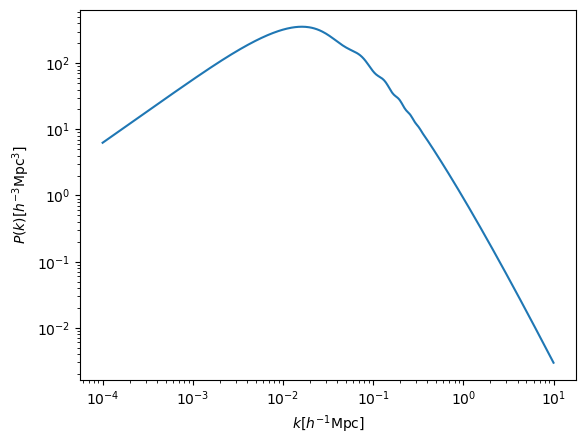

In [162]:
plt.loglog(kh, pk[0], label='theory')
plt.xlabel(r"$k [h^{-1} \mathrm{Mpc}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")

## Create an interpolator for the power spectrum

In [163]:
pk_interpolate = interp1d(kh, pk[0], kind='cubic', fill_value="extrapolate")

## Create the grid

In [164]:
side = 500              ## Mpc
Volume = side**3

n_cells = 100 ## cells per side
spacing = side/n_cells

print(spacing)

5.0


In [165]:
kF = 2*np.pi/side
kN = 2*np.pi/spacing

print(kF,"h/Mpc",kN, "h/Mpc")

0.012566370614359173 h/Mpc 1.2566370614359172 h/Mpc


In [166]:
kx = np.fft.fftfreq(n_cells, spacing)*np.pi*2
ky = np.fft.fftfreq(n_cells, spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cells, spacing)*np.pi*2  # using rfft reduces memory usage when the field is real

print(kx.shape, ky.shape, kz.shape)

(100,) (100,) (51,)


Remember that kx and ky have all the positive values first, than all the negative values. Use fftshift to reorder the values from the smaller to the bigger value


In [167]:
kx = np.fft.fftshift(kx)
ky = np.fft.fftshift(ky)

## Generate gaussian random field in Fourier space

In [168]:
pks = np.zeros((n_cells,n_cells,n_cells//2+1))      ## this will contain the values of the binned pk
pks.shape

(100, 100, 51)

In [169]:
## let's rewrite what fftfreq does
## for each location in the grid

for i in range(n_cells):
    kx = i if i <= n_cells //2 else i-n_cells   
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j<= n_cells // 2 else j-n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1):               ## by construction z contains only positive values of k
            kz = k * 2*np.pi/side
            knorm = np.sqrt(kx**2+ky**2+kz**2)

            pks[i,j,k] = pk_interpolate(knorm)

In [170]:
# generate Random field

## generate the phase of the field, uniform in 0,2pi

phase = np.random.uniform(size=pks.shape)*2*np.pi
phase.shape


(100, 100, 51)

In [171]:
## generate the real part of the field, normal distributed with variance given by pks
delta_k_norm = np.random.normal(size=pks.shape) * np.sqrt(pks*Volume)

In [172]:
## delta_k is the random complex field given by Re+jIm
delta_k = delta_k_norm *(np.cos(phase) +1j*np.sin(phase))

In [173]:
## transform back to configuration space
delta_x = np.fft.irfftn(delta_k, norm="backward")/spacing**3    ## why not Volume**3 ? Weird normalization due to fft normalization

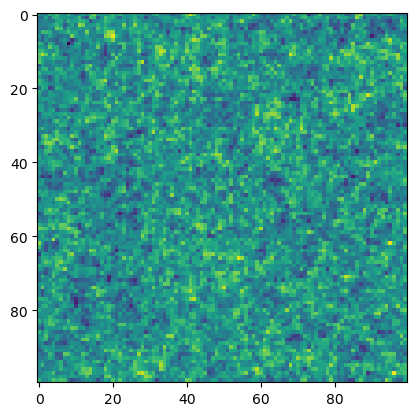

In [174]:
## plot a slize at fixed z of the configuration space overdensity field
plt.imshow(delta_x[:,:,2])

Text(0.5, 0, '$\\delta(x)$')

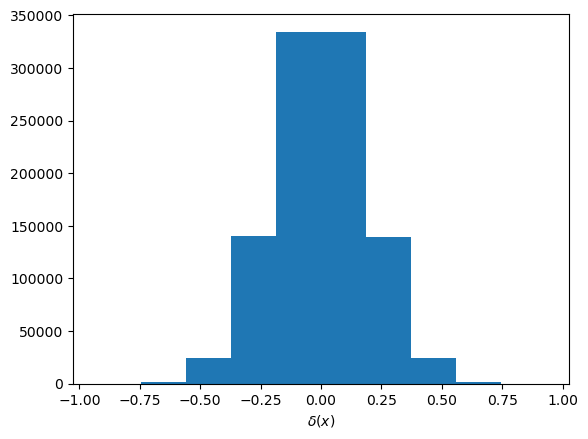

In [175]:
plt.hist(delta_x.flatten())
plt.xlabel('$\delta(x)$')

Note that if delta reaches values smaller than -1 I'm getting a non physical result -> we'll see methods to ensure this won't happen -> log normal fields

In [176]:
np.mean(delta_x.flatten())

-7.34329768900975e-06

In [177]:
np.var(delta_x.flatten())

0.03691788351299002

# Extract PS from synthetic random data

In [178]:
kx = np.fft.fftfreq(n_cells, spacing)*np.pi*2
ky = np.fft.fftfreq(n_cells, spacing)*np.pi*2
kz = np.fft.rfftfreq(n_cells, spacing)*np.pi*2

In [179]:
knorm = []
for i in range(n_cells):
    kx = i if i <= n_cells //2 else i-n_cells       ## this is due to the ordering in kx, ky: positive k first, then negative
    kx *= 2*np.pi/side
    for j in range(n_cells):
        ky = j if j<= n_cells // 2 else j-n_cells
        ky *= 2*np.pi/side
        for k in range(n_cells//2+1):               ## by construction z contains only positive values of k
            kz = k * 2*np.pi/side
            knorm.append(np.sqrt(kx**2+ky**2+kz**2))

In [180]:
delta_k_sq = np.abs(delta_k)**2

In [181]:
pks = delta_k_sq.flatten() / Volume     ## why divided? Weird normalization due to fft normalization

Text(0, 0.5, '$P(k) [h^{-3} \\mathrm{Mpc}^3]$')

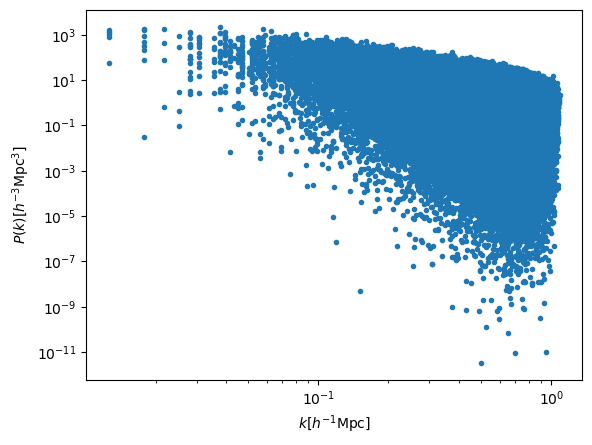

In [182]:
plt.loglog(knorm, pks, '.')
plt.xlabel(r"$k [h^{-1} \mathrm{Mpc}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")

In [183]:
edges = np.arange(kF, kN, kF)

In [184]:
pk_meas = np.zeros(len(edges)-1)
k_bin = (edges[1:]+edges[0:-1])/2   ## k at the center of the bin

In [185]:
np.min(knorm), np.max(knorm)

(0.0, 1.0882796185405306)

In [186]:
for i in range(len(k_bin)):
    k_selection = np.where((knorm>edges[i])&(knorm<edges[i+1]))[0]
    pk_meas[i] = np.mean(pks[k_selection])

/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/edoardo/miniconda3/envs/acc-env/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


/var/folders/lt/rxl5tbq10jx7cr45nr6962zm0000gq/T/ipykernel_12503/3500718936.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.loglog(k_bin, pk_meas, '-', label='measure', color='yellow', linestyle='--')


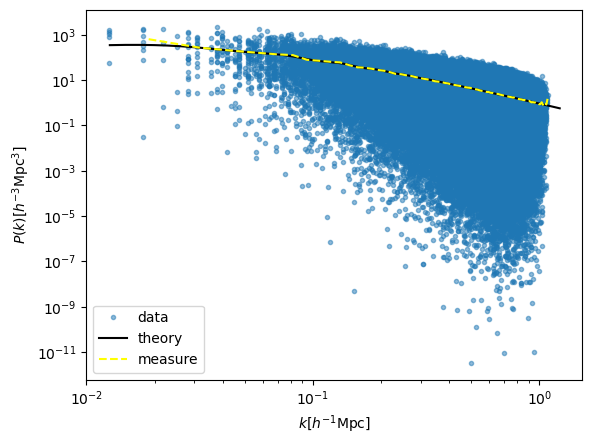

In [191]:
plt.loglog(knorm, pks, '.', label='data', alpha=0.5)
plt.loglog(kh[(kh>kF)&(kh<kN)], pk[0][(kh>kF)&(kh<kN)], label='theory', color = 'black')

plt.loglog(k_bin, pk_meas, '-', label='measure', color='yellow', linestyle='--')
plt.xlabel(r"$k [h^{-1} \mathrm{Mpc}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")
plt.legend()

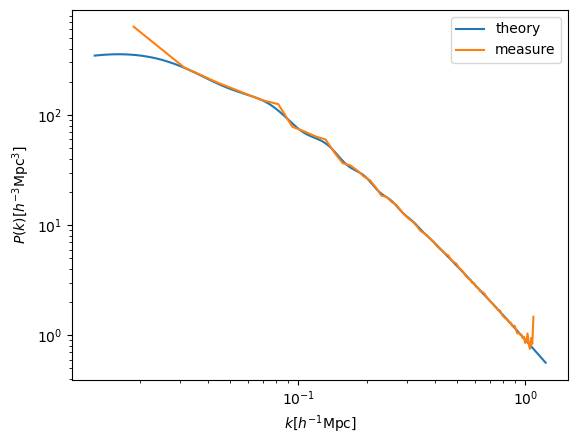

In [193]:
plt.loglog(kh[(kh>kF)&(kh<kN)], pk[0][(kh>kF)&(kh<kN)], label='theory')

plt.loglog(k_bin, pk_meas, '-', label='measure')
plt.xlabel(r"$k [h^{-1} \mathrm{Mpc}]$")
plt.ylabel(r"$P(k) [h^{-3} \mathrm{Mpc}^3]$")
plt.legend()

## Log normal mock

We want a delta field wich cannot go below -1. We use the following procedure:
1. generate the target power spectrum
2. compute the corresponding xi
3. compute a gaussian xi as $\xi_g = \log(1+\xi)$
4. compute its corresponding power spectrum
5. generate the gaussian field G(x) with this power spectrum
6. compute $\delta(x)= \log(G(x)-\sigma_G)-1$

delta has the target power spectrum but now has support [-1,+inf)



In [194]:
knorm = np.reshape(knorm, newshape=(n_cells,n_cells,int(n_cells/2+1)))

In [195]:
# get the PS on the grid
pks = pk_interpolate(knorm)

In [196]:
# get 2PCF on the grid

xi = np.fft.irfftn(pks) / spacing**3

In [197]:
xi.shape

(100, 100, 100)

In [198]:
# generate gaussian 2PCF
xi_g = np.log(1+xi)

In [199]:
# get PS from xi_g

pk_g = np.fft.rfftn(xi_g) * spacing**3

In [200]:
pk_g.shape

(100, 100, 51)

In [201]:
# generate G(k)

phase = np.random.uniform(size=pks.shape)*2*np.pi
G_k_norm = np.random.normal(size=pks.shape)*np.sqrt(pk_g*Volume)
G_k_norm[0,0,0] = 0

G_k = G_k_norm *(np.cos(phase)+1j*np.sin(phase))

G_k is a gaussian field such that it has pk_g as power spectrum

In [202]:
# Compute G(x)

G_x = np.fft.irfftn(G_k, norm='backward')/spacing**3

Text(0.5, 1.0, 'G(x)')

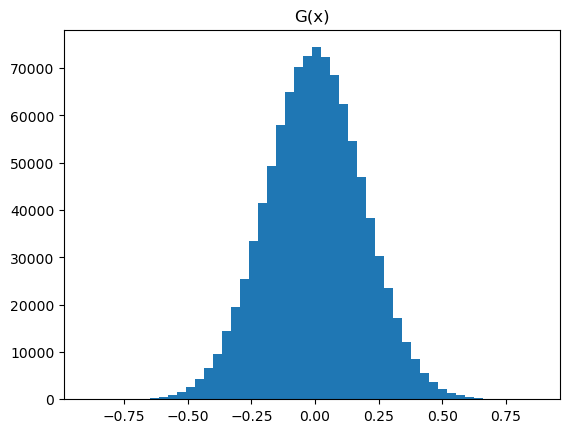

In [210]:
plt.hist(G_x.flatten(), histtype="bar", bins=50)
plt.title('G(x)')

We are interested not in G(x) but in its exponential

In [204]:
# get delta from G_x using lognormal transform

var_G = np.var(G_x)
delta_x = np.exp(G_x-var_G)-1

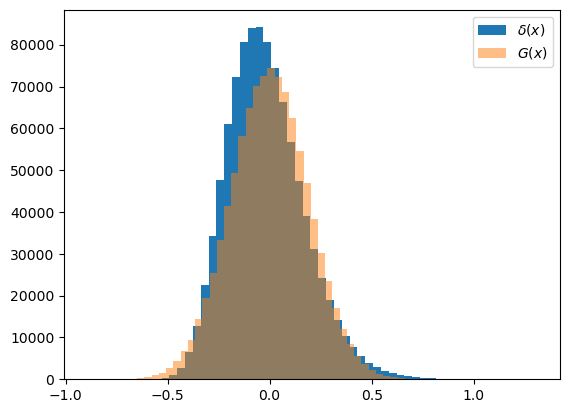

In [205]:
plt.hist(delta_x.flatten(), histtype="bar", bins=50, label='$\delta(x)$')
plt.hist(G_x.flatten(), histtype="bar", bins=50, alpha=0.5, label='$G(x)$')
plt.legend()

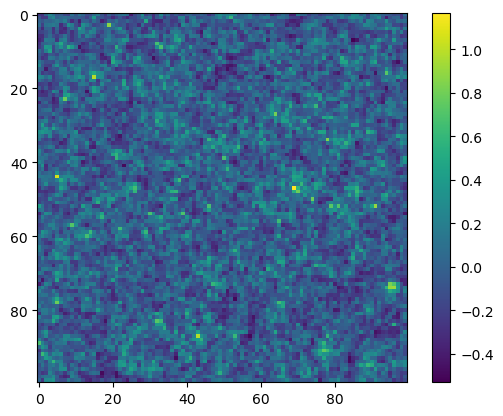

In [208]:
plt.imshow(delta_x[:,:,5])
plt.colorbar()